In [555]:
import os
import json
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import json
import numpy as np
from torchvision import datasets, transforms

class AddNoise(object):
  def __init__(self, scale):
    self.scl = scale
  def __call__(self, x):
    self.noise = torch.rand_like(x)/ self.scl
    return (x -self.noise )
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 /255.0  # input threshold for [0..255] gray level, convert to [0..1]
  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type
class DetachWhite(object):
  def __init__(self, pixel):
    self.pixel = pixel
  def __call__(self, x):
    self.detach_pixel=x[:,:self.pixel]
    return (self.detach_pixel)
def crop_image(img, coords) :
    x, y, w, h = coords
    xmin, ymin = int(x), int(y)
    xmax, ymax = int(x + w), int(y + h)
    cropped_img = img.crop([xmin, ymin, xmax, ymax]) 
    return cropped_img

def get_crop_image(sample, image_path,is_train):
    json_path='/data/datasets/ai_hub_sketch_json'
    json_name = image_path.split('/')[-1].split('.')[0] + ".json"
    class_name = json_name[0]
    print(class_name)
    assert class_name in ['m', 'w']
    print(os.path.join(json_path, json_name))
    with open(os.path.join(json_path, json_name), 'r') as f :   
        part_anns = json.load(f)['annotations']['bbox'][0]
    
    assert part_anns['label'] == '사람전체'
    coords = [part_anns['x'], part_anns['y'], part_anns['w'], part_anns['h']]
    print(coords)
    sample_img = crop_image(sample, coords)
    resize=transforms.Resize((224,224))
    sample_img = resize((sample_img))
    return sample_img

In [556]:
import argparse
import cv2
import numpy as np
import torch
from torchvision import models
from torchvision import transforms
from pytorch_grad_cam import GradCAM, \
    HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
from timm.models.layers import trunc_normal_

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import os

from PIL import Image
methods = \
        {"gradcam": GradCAM,
         "hirescam": HiResCAM,
         "scorecam": ScoreCAM,
         "gradcam++": GradCAMPlusPlus,
         "ablationcam": AblationCAM,
         "xgradcam": XGradCAM,
         "eigencam": EigenCAM,
         "eigengradcam": EigenGradCAM,
         "layercam": LayerCAM,
         "fullgrad": FullGrad,
         "gradcamelementwise": GradCAMElementWise}
topil = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256,256)),
            # DetachWhite(30)
                # transforms.RandomRotation((180,180)),
            
            # transforms.RandomRotation((90,90))
            # transforms.Grayscale(3),
            # transforms.RandomInvert(1),
            # transforms.ToTensor(),
            # ThresholdTransform(10),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5],
            #                         std=[0.5, 0.5, 0.5])
            ])


In [557]:
import torchvision
model=models.efficientnet_b3(pretrained=True)#pretrained=True,progress=False)
# model.classifier[1] = torch.nn.Linear(1280, 250)
# model=torchvision.models.resnet18(pretrained=True)
# in_ft = model.fc.in_features 
# model.fc = torch.nn.Linear(in_ft, 2)

data_path='/data/datasets/imagenet-sample-images'
# import random
# weight='/data/jong980812/project/mae/result/tu_berlin/5e-2/OUT/01/checkpoint-29.pth'
# checkpoint = torch.load(weight, map_location='cpu')
# print("Load pre-trained checkpoint from: %s" % weight)
# checkpoint_model = checkpoint['model']
# state_dict = model.state_dict()
model.eval()
# # msg = model.load_state_dict(checkpoint_model, strict=False)
# def set_conv_padding_mode(model, padding_mode='replicate'):
#   for name, layer in model.named_modules():
#       if isinstance(layer, torch.nn.Conv2d):
#           layer.padding_mode = padding_mode
# set_conv_padding_mode(model,padding_mode='zeros')
# print(msg)
model


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /home/jong980812/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:04<00:00, 11.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [558]:
targets = None
target_layers = [model.features[-1][0]]
# target_layers = [model.layer4]
target_layers


[Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [559]:
def get_img(given_path, norm_mode='no'):   
    image_path=given_path
    rgb_img = Image.open(image_path)
    norm={
        "0.96": transforms.Normalize(mean=[0.96, 0.96, 0.96],
                                        std=[0.1, 0.1, 0.1]),
        "0.5":transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                        std=[0.5, 0.5, 0.5]),
        "imagenet":transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225] )
    }
    if norm_mode=='no':
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                # transforms.Grayscale(3),
                # transforms.CenterCrop((224,224)),
                # transforms.CenterCrop(224),\
                # transforms.RandomRotation((180,180)),
            # transforms.RandomInvert(1),
            transforms.ToTensor(),
            # DetachWhite(30)
            # AddNoise(50),
            # ThresholdTransform(30),
            ])
    else:
        transform = transforms.Compose([
                transforms.Resize((256,256)),
                # transforms.CenterCrop(224),
                # transforms.RandomRotation((180,180)),
                # transforms.Grayscale(3),
                # transforms.RandomInvert(1),
                transforms.ToTensor(),
                # AddNoise(50),
                # ThresholdTransform(20),
                norm[norm_mode]
                ])
    # body_image=get_crop_image(rgb_img,image_path,False)
    # input_tensor = transform(body_image).unsqueeze(0)
    # input_tensor_asd = transform(rgb_img).unsqueeze(0)

    input_tensor=transform(rgb_img).unsqueeze(0)
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img,(256,256))
    print(transform) 
    # rgb_img = np.float32(body_image) / 255
    rgb_img = np.float32(rgb_img) / 255
    # rgb_img=np.transpose(transform((rgb_img)),(1,2,0))
    # rgb_img=np.array(rgb_img,dtype=np.float32)
    return rgb_img, input_tensor, image_path

In [560]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [561]:
cam_algorithm = methods['gradcam']
def get_cam_image(input_tensor, rgb_img, target_model):
    with cam_algorithm(model=target_model,
                        target_layers=target_layers,
                        use_cuda=False) as cam:

        # AblationCAM and ScoreCAM have batched implementations.
        # You can override the internal batch size for faster computation.
        cam.batch_size = 32
        grayscale_cam,model_predict,activations, weighted_activations  = cam(
                            input_tensor=input_tensor,
                            targets=targets,
                            aug_smooth=False,
                            eigen_smooth=False)

        # Here grayscale_cam has only one image in the batch
        # print(grayscale_cam)
        grayscale_cam = grayscale_cam[0, :]
        
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True,image_weight=0.5)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2RGBA)
        return cam_image, model_predict,activations, weighted_activations 

n02127052_lynx.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[287]


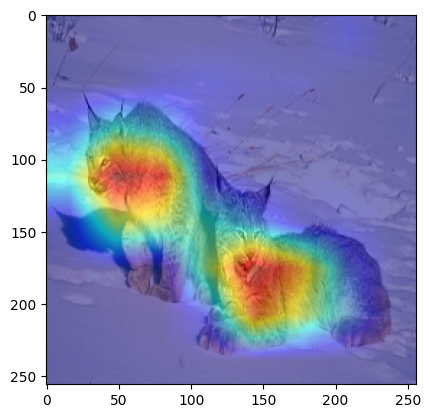

n03141823_crutch.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[523]


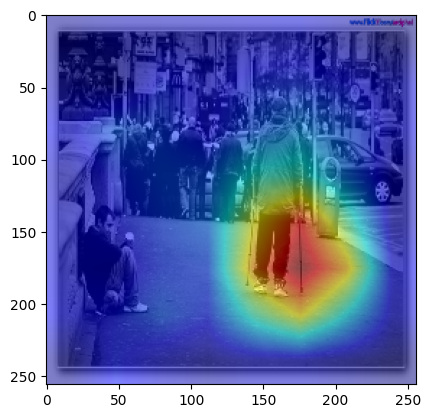

n02120505_grey_fox.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[280]


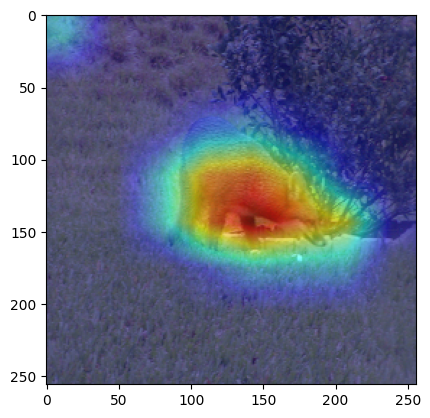

n12057211_yellow_lady's_slipper.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[986]


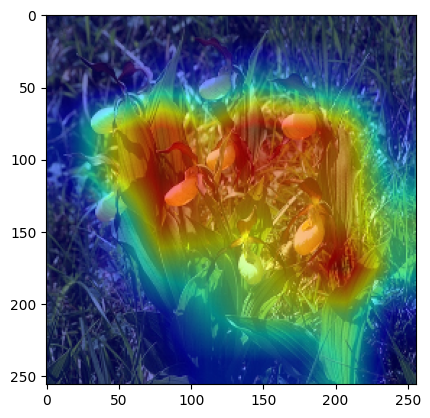

n04597913_wooden_spoon.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[910]


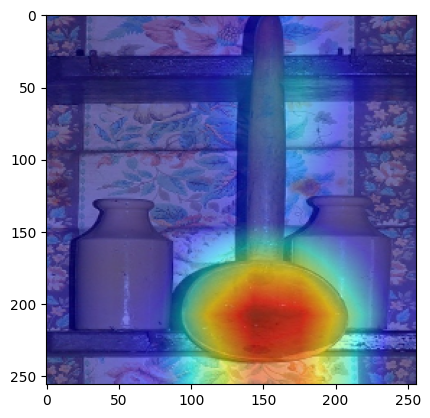

n02892767_brassiere.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[459]


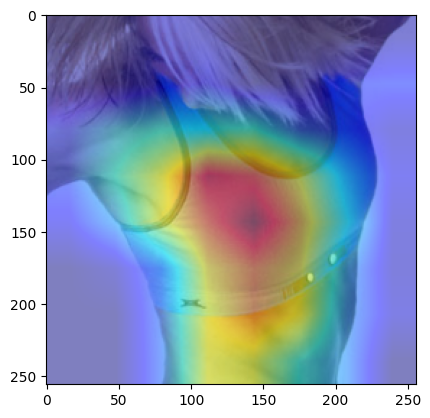

n04540053_volleyball.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[890]


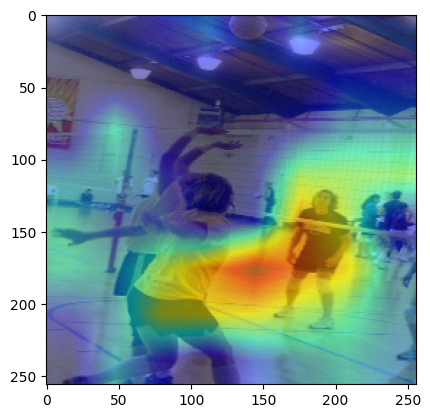

n04589890_window_screen.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[904]


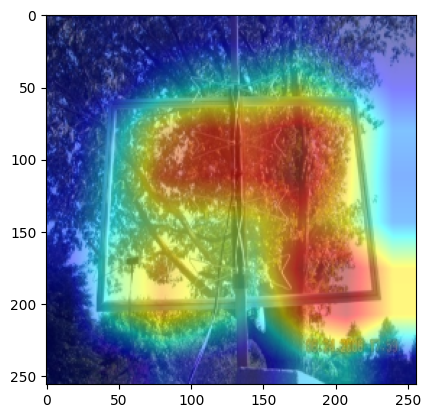

n02484975_guenon.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[370]


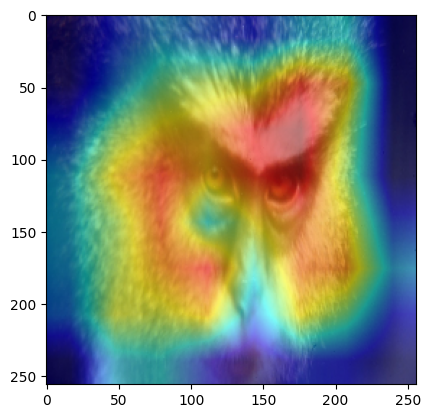

n03457902_greenhouse.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[580]


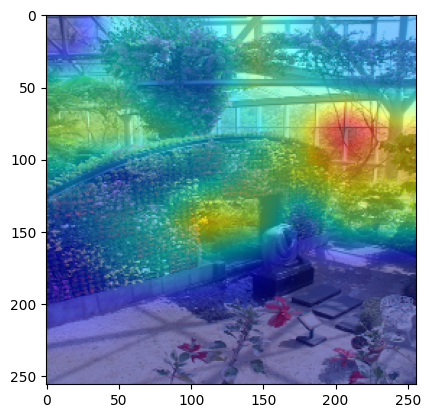

n03642806_laptop.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[620]


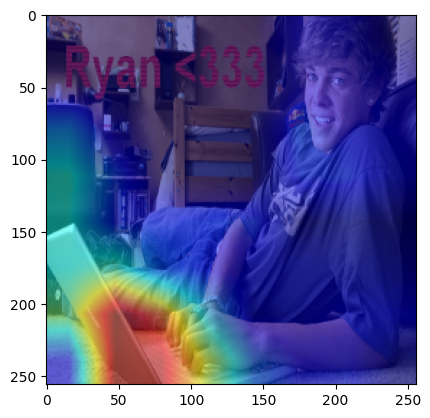

n09835506_ballplayer.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[981]


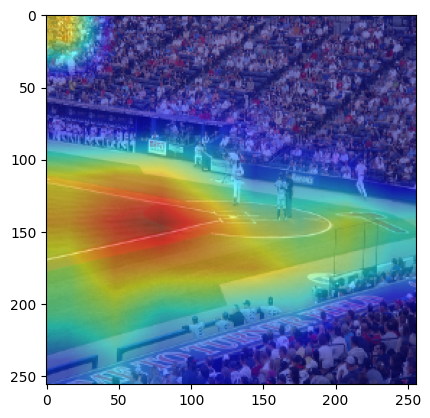

n03467068_guillotine.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[583]


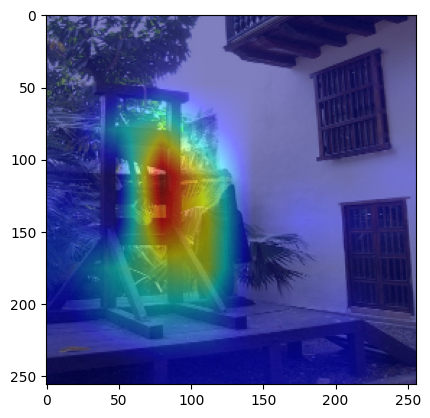

n03478589_half_track.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[586]


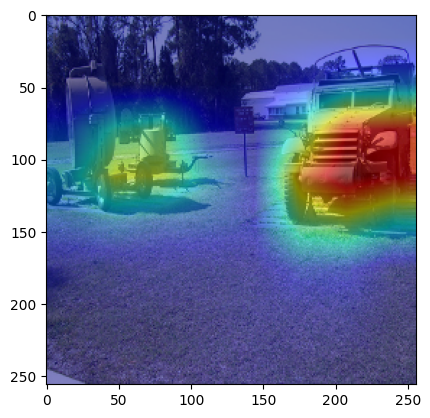

n07590611_hot_pot.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[926]


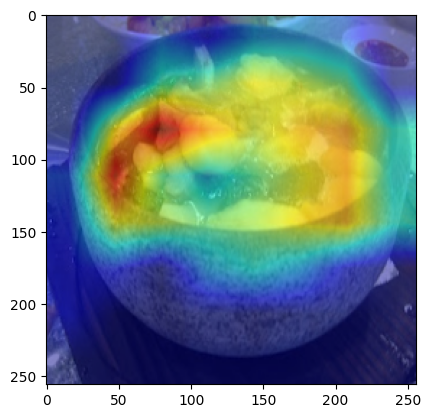

n04081281_restaurant.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[762]


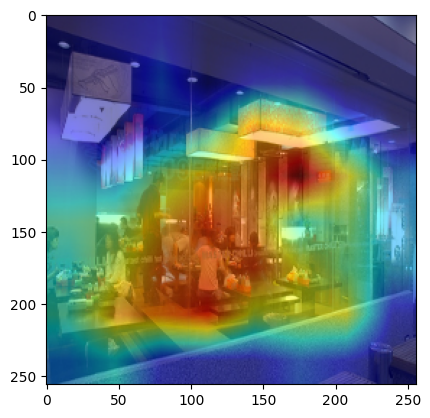

n04243546_slot.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[800]


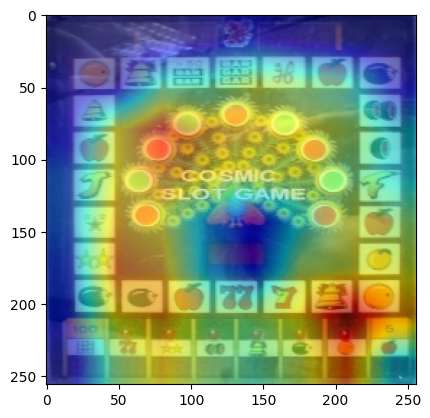

n02488702_colobus.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[375]


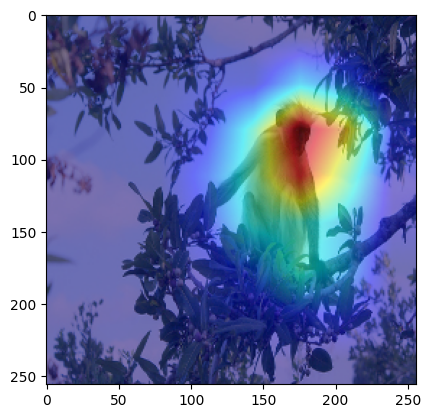

n04376876_syringe.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[845]


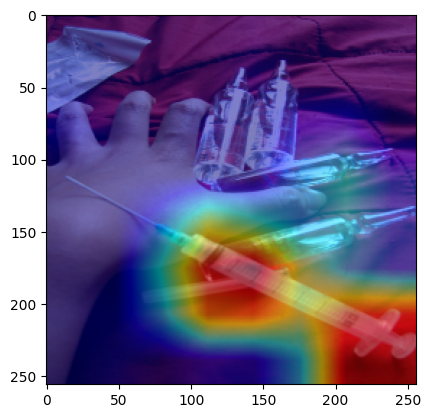

n01930112_nematode.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[111]


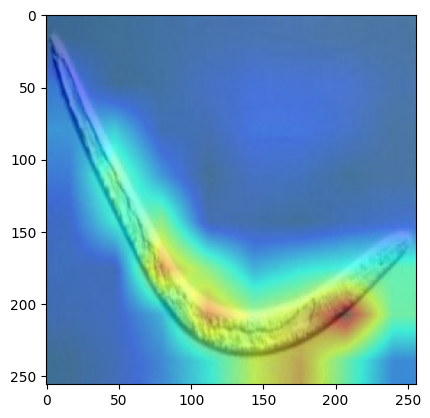

n03791053_motor_scooter.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[670]


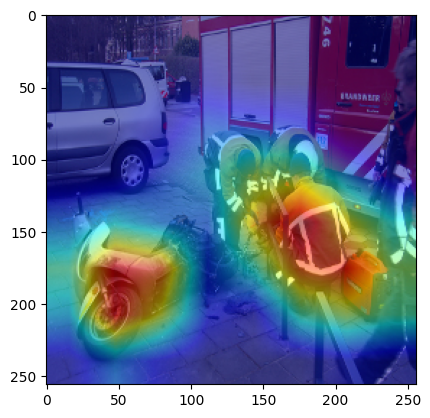

n04355338_sundial.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[835]


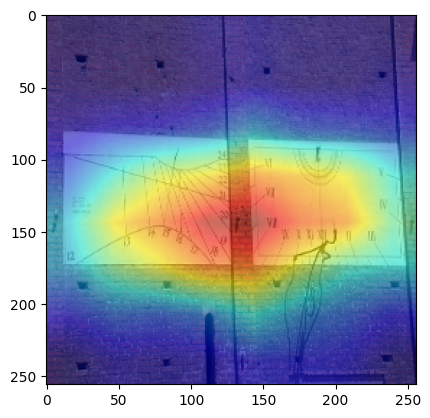

n03733281_maze.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[868]


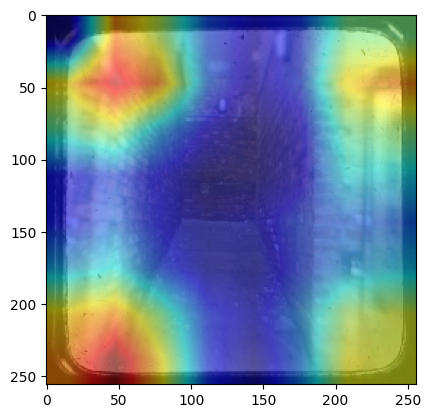

n02454379_armadillo.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[363]


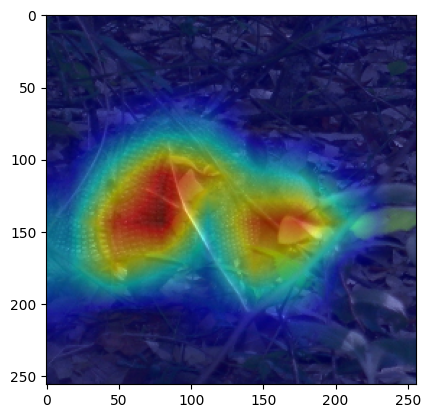

n04259630_sombrero.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[515]


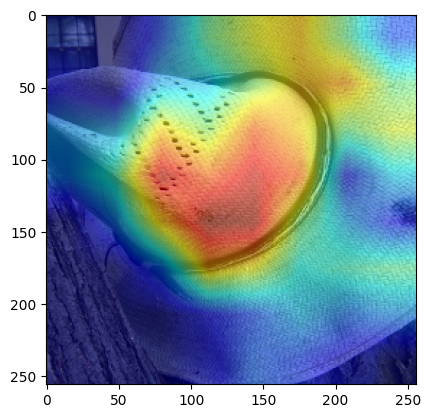

n02092002_Scottish_deerhound.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[177]


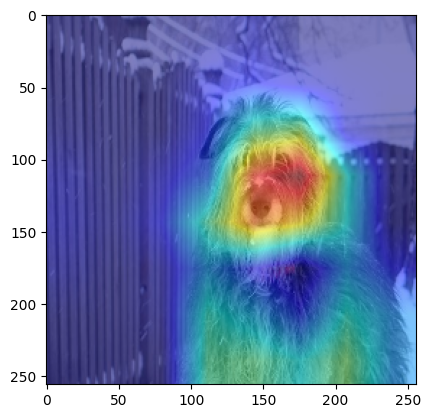

n02281406_sulphur_butterfly.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[325]


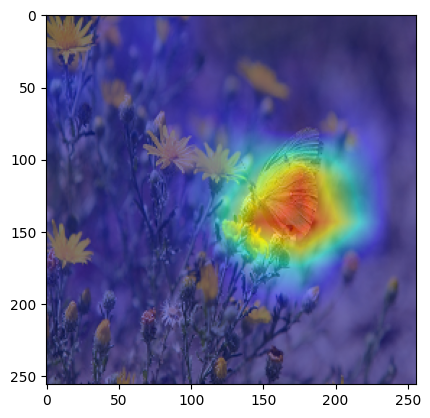

n02321529_sea_cucumber.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[329]


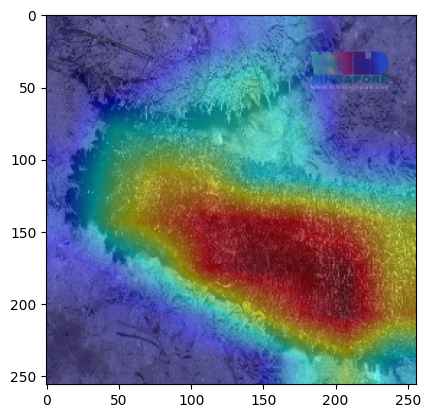

n03530642_honeycomb.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[599]


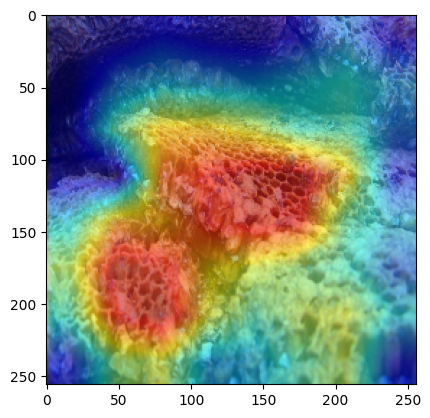

n01749939_green_mamba.JPEG
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
torch.Size([1, 3, 256, 256])
[64]


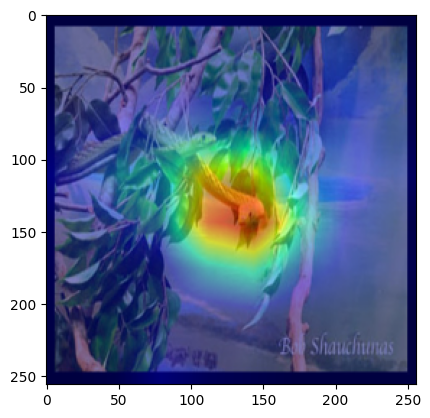

-----------TD------------


In [562]:
from matplotlib import pyplot as plt
# for img in os.listdir(data_path)[7:]:
for img in os.listdir(data_path)[:30]:
    # img=os.listdir(data_path_ASD)[i]
    #[random.randint(1,500)]
    image_path=os.path.join(data_path,img)
    print(img)
    rgb_img, input_tensor, image_path=get_img(image_path,'imagenet')
    # print(input_tensor)
    cam_image,model_predict,activations, weights =get_cam_image(input_tensor,rgb_img,model) 
    print(model_predict)
    plt.imshow(topil((cam_image)))
    plt.show()
    # break

print('-----------TD------------')
# for img in os.listdir(data_path_TD):
#     # img=os.listdir(data_path_TD)[i]
#     #[random.randint(1,500)]
#     image_path=os.path.join(data_path_TD,img)
#     rgb_img, input_tensor, image_path=get_img(image_path,'no')
#     # print(input_tensor)
#     cam_image,model_predict,activations, weights =get_cam_image(input_tensor,rgb_img,model) 
#     print(model_predict)
#     plt.imshow(topil((cam_image)))
#     plt.show()
#     # break
    # break

In [563]:
sorted_weights=weights[0].argsort()[::-1]
feature_map= torch.nn.Sequential(*(list(model.children())[0][:8])) # input to penultimate layer

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a 2D tensor (e.g., a NumPy array)
data = feature_map(input_tensor).squeeze(0).detach().numpy()
print(data.shape)
for i in sorted_weights[:15]:
    # print(i)
# Create a heatmap
    plt.imshow(data[i], cmap='gray')  # You can choose a different colormap if needed
    plt.colorbar()  # Add a colorbar to the plot
    plt.title('Heatmap Example')  # Set a title for the heatmap
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


(384, 8, 8)


IndexError: index 1478 is out of bounds for axis 0 with size 384

In [ ]:
type(data)

numpy.ndarray

In [ ]:

rgb_img, input_tensor, image_path=get_img('/data/jong980812/project/mae/catanddog.jpeg','no')
cam_image,model_predict,_,_=get_cam_image(input_tensor,rgb_img,model) 
print(model_predict)
plt.imshow(topil(cam_image))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/jong980812/project/mae/catanddog.jpeg'

In [ ]:
image_path

'/data/jong980812/project/mae/catanddog.jpeg'

In [ ]:
image_path

'/data/jong980812/project/mae/catanddog.jpeg'

In [ ]:
rgb_img.shape

(224, 224, 3)

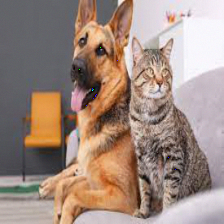

In [ ]:
topil(input_tensor.squeeze(0))

In [ ]:
input_tensor.mean()

tensor(0.5591)